In [168]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt 
from sklearn.covariance import EmpiricalCovariance
from sklearn.linear_model import LinearRegression

In [169]:
df = pd.read_csv("gp_data_1986_to_2015.csv")
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,1.91,5.60,2.48,1.67,-0.09,2.82,6.63,2.08,2.47,3.91
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,10.61,7.03,8.85,7.21,9.27,11.04,7.41,6.99,8.18,11.28
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,5.61,3.22,7.41,9.11,6.42,7.22,5.31,9.32,5.49,6.52
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,-0.93,-2.64,1.70,-0.70,3.86,-0.58,-6.10,-3.22,-3.29,-4.69
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.07,0.70,5.52,11.95,4.89,4.20,5.72,-1.21,5.19,6.32


In [170]:
Rf = df['RF'].astype(float).values.copy()
    
for column in df.columns:
    if column in ['Month','Mkt-RF','RF']:
        continue
    df[column] -= Rf

df2 = df.drop(['Month','Mkt-RF','RF'], axis = 1)

df2.head()

df_mkt = df['Mkt-RF']

In [171]:
df_train = df2.iloc[:300]
df_test = df2.iloc[300:]

df_mkt_train = df_mkt.iloc[:300]
df_mkt_test = df_mkt.iloc[300:]

In [172]:
def estimate_V (data):
    
    ###########
    # (Basic) Estimate of the covariance matrix from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of covariance matrix of asset returns
    ###########
    
    Vhat = EmpiricalCovariance().fit(data).covariance_
    
    return Vhat

def estimate_mu (data):
    
    ###########
    # (Basic) Estimate of the expected return vector from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of expected return vector of all assets
    ###########
    
    mu_hat = EmpiricalCovariance().fit(data).location_
    
    return mu_hat

In [173]:
def tangency(mu, V):
    
    ###########
    # Construct the tangency portfolio using the closed form method
    # Input: mu is Estimated expected vector and V is the estimated covariance matrix
    # Output: The weights of the tangency portfolio
    ###########

    
    #tangency portfolio
    w_t = np.linalg.inv(V) @ mu
    w_t /= np.sum(w_t)

    return w_t

def gmv(V):
    
    ###########
    # Construct the global minimum variance portfolio using the closed form method
    # Input: V is the estimated covariance matrix
    #        NB: the expected return vector is not needed here!
    # Output: The weights of the global minimum variance portfolio
    ###########

    #GMV
    n = len(V)
    w_g = np.linalg.inv(V) @ np.ones(n)
    w_g /= np.sum(w_g)
    
    return w_g

def ewp(n):
    
    ###########
    # Construct the equally weighted portfolio
    # Input: n is the number of assets
    #        NB: neither the expected return vector nor covariance matrix is not needed here!
    # Output: The weights of the equally weighted portfolio
    ###########

    #GMV
    
    return np.ones(n)/n

In [174]:
def evaluate_portfolio_performance_on_data(w, data_evaluate):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the return data to evaluate on
    # Input: data contains historical return information (every column corresponds to an asset)
    #        w is the portfolio weight vector
    #        (NB: risk-free rate has already been assumed to be zero)
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    # Sanity check for the input format
    w = w.reshape((-1))
    if (data_evaluate.shape[1] != len(w)):
        print('Warning: data and w should contain the same number of assets')
    ### End of sanity check
    
    V = estimate_V (data_evaluate)
    mu = estimate_mu (data_evaluate)
    
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

In [175]:
def get_EF_on_data (w_t, w_g, data_evaluate):

    ###########
    # Get the (evaluated) efficient frontier curve using the two-fund separation method
    #
    # Input: data contains historical return information to evaluate on (every column corresponds to an asset)
    #        w_t and w_g are the constructed tangency and global minimum variance portfolios, respectively
    #        (NB: if w_t and w_g are obtained from the training data but "data" is actually testing data,
    #         then the output EF could be highly sub-optimal!)
    # Output: The risk-return combinations of portfolios on the (evaluated) EF 
    ###########
    
    trange = np.arange(0,1.1,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['sigma']
        Er_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range

In [176]:
sigma_range, Er_range = get_EF_on_data (tangency(est_mu,est_V), gmv(est_V), df_train)

In [177]:
def plot_evaluation_results_in_sample (data_train):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_train" as well
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    w_e = ewp(data_train.shape[1])
    
    print('The in-sample tangency portfolio is: ', np.round(w_t_train,3))
    print('The in-sample global minimum variance portfolio is: ', np.round(w_g_train,3))
    
    
    sigma_range, Er_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    plt.plot(sigma_range, Er_range, label = 'EF')
    
    # tangency portfolio (TAN)
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_train, data_train)['sigma'], evaluate_portfolio_performance_on_data (w_t_train, data_train)['Er'], marker='*', color = 'red',label = 'TAN')
    
    # global minimum variance portfolio (GMV)
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_train, data_train)['sigma'], evaluate_portfolio_performance_on_data (w_g_train, data_train)['Er'], marker='^', color = 'red',label = 'GMV')
    
    # equally weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data_train)['sigma'], evaluate_portfolio_performance_on_data (w_e, data_train)['Er'], marker='+', color = 'red',label = 'EWP')
    
    # Market portfolio (MKT)
    plt.scatter(df_mkt_train.std(),df_mkt_train.mean(), marker='o', color = 'red',label = 'MKT')
    
    plt.scatter(df_train.std(),df_train.mean())

    plt.legend()
    plt.title('Risk-Return Diagram (In-sample Analysis)')
    plt.xlabel('$\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    
    plt.show()


In [373]:
est_V = estimate_V(df_train)
est_mu = estimate_mu(df_train)

In [179]:
ewp(48)

array([0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333])

In [180]:
tangency(est_mu,est_V)

array([-0.18292249,  0.14788476,  0.13624552,  0.04731633,  0.36379986,
       -0.4014356 ,  0.4314339 , -0.2325813 , -0.12209935,  0.0200519 ,
       -0.02537325,  0.60764808,  0.28524122, -0.20081764,  0.44104752,
        0.11493964, -0.08042746, -0.06395487, -0.35477053,  0.0151222 ,
       -0.02491599,  0.56062191,  0.03889951, -0.09052493, -0.12667517,
        0.30668896, -0.04848308,  0.52728286, -0.02080383,  0.4329099 ,
        0.49708512, -0.55406262, -0.39659009,  0.50648549, -0.3954105 ,
        0.30800451, -0.15249354,  0.17480473, -0.12094145,  0.38979887,
       -0.88880643,  0.24123107, -0.00105009, -0.0059709 , -0.34836548,
       -0.41199683,  0.36570108, -0.70877153])

In [181]:
gmv(est_V)

array([ 0.07409797,  0.04513076,  0.00774769, -0.00141828, -0.02395589,
       -0.01448216, -0.04284023,  0.09945703,  0.21599316, -0.07537178,
       -0.04683125,  0.08367975,  0.02789712, -0.17541636, -0.08368617,
       -0.01487656, -0.09087267, -0.15255654, -0.07049473,  0.06777468,
       -0.03280804, -0.12934991, -0.07515589, -0.13788494, -0.01604317,
        0.10358197,  0.05686438,  0.00059705, -0.01713664,  0.15746386,
        0.41368534,  0.09980063, -0.03347467, -0.10657886,  0.09977718,
        0.07092004, -0.03736714,  0.1632723 ,  0.11588471,  0.24796052,
        0.02325478,  0.19114447,  0.06823897, -0.0898092 , -0.06116797,
        0.0939144 ,  0.02062589, -0.01918559])

In [182]:
df_train.mean()

Agric    0.658833
Food     0.740800
Soda     0.835933
Beer     0.928433
Smoke    1.179633
Toys     0.464367
Fun      0.883933
Books    0.357433
Hshld    0.637400
Clths    0.712267
Hlth     0.458867
MedEq    0.763967
Drugs    0.780700
Chems    0.750200
Rubbr    0.681767
Txtls    0.529300
BldMt    0.699933
Cnstr    0.655800
Steel    0.601367
FabPr    0.392300
Mach     0.791800
ElcEq    0.997267
Autos    0.545900
Aero     0.741833
Ships    0.467400
Guns     0.606600
Gold     0.631167
Mines    1.143567
Coal     1.473000
Oil      0.805833
Util     0.534367
Telcm    0.482400
PerSv    0.348233
BusSv    0.810133
Comps    0.666400
Chips    0.770067
LabEq    0.654833
Paper    0.573433
Boxes    0.766100
Trans    0.598033
Whlsl    0.447967
Rtail    0.723033
Meals    0.699167
Banks    0.600200
Insur    0.586200
RlEst    0.041267
Fin      0.842700
Other    0.133300
dtype: float64

In [183]:
df_train.std()

Agric     6.515449
Food      4.666901
Soda      7.477219
Beer      5.443109
Smoke     7.211306
Toys      6.962345
Fun       7.745372
Books     5.854143
Hshld     4.718053
Clths     6.869138
Hlth      6.781168
MedEq     5.280232
Drugs     5.082943
Chems     5.913248
Rubbr     6.299689
Txtls     8.438394
BldMt     6.465546
Cnstr     7.171854
Steel     8.419985
FabPr     7.109699
Mach      6.829273
ElcEq     6.679670
Autos     7.900895
Aero      6.485974
Ships     7.605019
Guns      6.509836
Gold     11.078880
Mines     7.789968
Coal     11.183699
Oil       5.356932
Util      4.109989
Telcm     5.400499
PerSv     6.209793
BusSv     6.965598
Comps     8.326538
Chips     8.554589
LabEq     7.229432
Paper     5.666205
Boxes     6.315217
Trans     5.559001
Whlsl     5.079726
Rtail     5.682582
Meals     5.374822
Banks     6.402142
Insur     5.620091
RlEst     7.797821
Fin       6.963870
Other     7.083461
dtype: float64

In [184]:
df_train.mean()/df_train.std()

Agric    0.101119
Food     0.158735
Soda     0.111797
Beer     0.170570
Smoke    0.163581
Toys     0.066697
Fun      0.114124
Books    0.061056
Hshld    0.135098
Clths    0.103691
Hlth     0.067668
MedEq    0.144684
Drugs    0.153592
Chems    0.126868
Rubbr    0.108222
Txtls    0.062725
BldMt    0.108256
Cnstr    0.091441
Steel    0.071421
FabPr    0.055178
Mach     0.115942
ElcEq    0.149299
Autos    0.069093
Aero     0.114375
Ships    0.061459
Guns     0.093182
Gold     0.056970
Mines    0.146800
Coal     0.131710
Oil      0.150428
Util     0.130017
Telcm    0.089325
PerSv    0.056078
BusSv    0.116305
Comps    0.080033
Chips    0.090018
LabEq    0.090579
Paper    0.101202
Boxes    0.121310
Trans    0.107579
Whlsl    0.088187
Rtail    0.127237
Meals    0.130082
Banks    0.093750
Insur    0.104304
RlEst    0.005292
Fin      0.121010
Other    0.018818
dtype: float64

In [188]:
def beta13 (d):
    beta = list()
    for i in d:
        beta_w = (np.cov(d[i], df_mkt_train)[0,1])/df_mkt_train.var()
        beta.append(beta_w)
    
    return beta

In [296]:
beta13(df_train)

[0.7399046617624645,
 0.596968460822974,
 0.863437343977872,
 0.6627796134783649,
 0.6268906627599798,
 1.0345393229915392,
 1.3280239288940587,
 1.0146562092314817,
 0.7242526491128936,
 1.109514591684134,
 0.8151671887625204,
 0.8453470593893995,
 0.7413491820828114,
 1.013846047931785,
 1.04601163045411,
 1.1813604777644793,
 1.1034335109425224,
 1.1676942933632783,
 1.4338771471113883,
 1.0312245766034054,
 1.2450733244575154,
 1.2381360272152826,
 1.2445474384312105,
 1.0183988414426048,
 0.9970805472539981,
 0.5719911083029552,
 0.4163630218520024,
 1.0496699649716597,
 1.0691288582314107,
 0.6683108450416942,
 0.41806010305107943,
 0.9319364208333605,
 0.922926808939673,
 1.3021533041394824,
 1.392022978289846,
 1.492760150824603,
 1.2893552634414842,
 0.9119057734155699,
 0.9484329587759474,
 0.9304580122099175,
 0.9090973158088372,
 0.9871817741253607,
 0.8521947186266381,
 1.0575852706239792,
 0.9116727925138188,
 1.0376895420278924,
 1.309986415907109,
 1.1339191568485922]

In [191]:
evaluate_portfolio_performance_on_data(ewp(48), df_train)

{'Er': 0.6707381944444444,
 'sigma': 4.832559944686334,
 'var': 23.353635618986786,
 'Sharpe': 0.13879562842918441}

In [192]:
evaluate_portfolio_performance_on_data(gmv(est_V), df_train)

{'Er': 0.44140303365943556,
 'sigma': 2.8256536216740384,
 'var': 7.98431838967961,
 'Sharpe': 0.15621271845695278}

In [193]:
evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_train)

{'Er': 2.8651474081641517,
 'sigma': 7.199042741621267,
 'var': 51.826216395689855,
 'Sharpe': 0.3979900538163639}

In [229]:
ewp_array = np.array([[evaluate_portfolio_performance_on_data(ewp(48), df_train)['Er'],evaluate_portfolio_performance_on_data(ewp(48), df_train)['sigma'],evaluate_portfolio_performance_on_data(ewp(48), df_train)['Sharpe']]])
gmv_array = np.array([[evaluate_portfolio_performance_on_data(gmv(est_V), df_train)['Er'],evaluate_portfolio_performance_on_data(gmv(est_V), df_train)['sigma'],evaluate_portfolio_performance_on_data(gmv(est_V), df_train)['Sharpe']]])
tangency_array = np.array([[evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_train)['Er'],evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_train)['sigma'],evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_train)['Sharpe']]])
market = np.array([[df_mkt_train.mean(),df_mkt_train.std(),df_mkt_train.mean()/df_mkt_train.std()]])

summary = pd.DataFrame(np.transpose(np.concatenate((market, ewp_array, tangency_array, gmv_array))))
summary.columns = ['market', 'ewp', 'tangency', 'gmv']
summary

,market,ewp,tangency,gmv
0,0.561467,0.670738,2.865147,0.441403
1,4.657505,4.832560,7.199043,2.825654
2,0.120551,0.138796,0.397990,0.156213


In-sample analysis
The in-sample tangency portfolio is:  [-0.183  0.148  0.136  0.047  0.364 -0.401  0.431 -0.233 -0.122  0.02
 -0.025  0.608  0.285 -0.201  0.441  0.115 -0.08  -0.064 -0.355  0.015
 -0.025  0.561  0.039 -0.091 -0.127  0.307 -0.048  0.527 -0.021  0.433
  0.497 -0.554 -0.397  0.506 -0.395  0.308 -0.152  0.175 -0.121  0.39
 -0.889  0.241 -0.001 -0.006 -0.348 -0.412  0.366 -0.709]
The in-sample global minimum variance portfolio is:  [ 0.074  0.045  0.008 -0.001 -0.024 -0.014 -0.043  0.099  0.216 -0.075
 -0.047  0.084  0.028 -0.175 -0.084 -0.015 -0.091 -0.153 -0.07   0.068
 -0.033 -0.129 -0.075 -0.138 -0.016  0.104  0.057  0.001 -0.017  0.157
  0.414  0.1   -0.033 -0.107  0.1    0.071 -0.037  0.163  0.116  0.248
  0.023  0.191  0.068 -0.09  -0.061  0.094  0.021 -0.019]


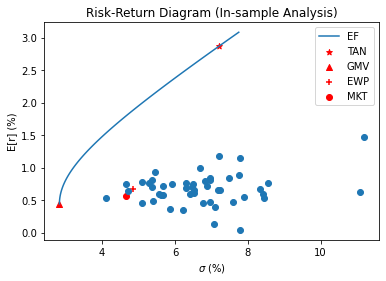

In [195]:
print('In-sample analysis')
plot_evaluation_results_in_sample (df_train)

In [199]:
def beta_p(weights):
    beta = (np.array(beta13(df_train)) * weights).sum()
    
    return beta

In [200]:
beta_range = np.array([0,1])
Er_range = np.array([0,df_mkt_train.mean()])

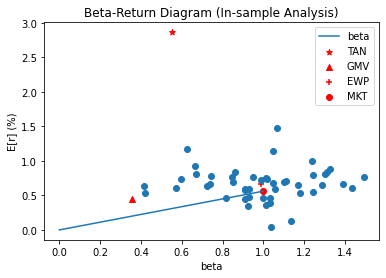

In [202]:
plt.plot(beta_range, Er_range, label = 'beta')
    
# tangency portfolio (TAN)
plt.scatter( beta_p(tangency(est_mu,est_V)), evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_train)['Er'], marker='*', color = 'red',label = 'TAN')
    
# global minimum variance portfolio (GMV)
plt.scatter( beta_p(gmv(est_V)), evaluate_portfolio_performance_on_data(gmv(est_V), df_train)['Er'], marker='^', color = 'red',label = 'GMV')
    
# equally weighted portfolio (EWP)
plt.scatter( beta_p(ewp(48)), evaluate_portfolio_performance_on_data(ewp(48), df_train)['Er'], marker='+', color = 'red',label = 'EWP')
    
# equally weighted portfolio (EWP)
plt.scatter(1,df_mkt_train.mean(), marker='o', color = 'red',label = 'MKT')
    
plt.scatter(beta13(df_train),df_train.mean())

plt.legend()
plt.title('Beta-Return Diagram (In-sample Analysis)')
plt.xlabel('beta')
plt.ylabel('E[r] (%)')
    
plt.show()

In [204]:
beta_avg = np.array(beta13(df_train)).mean()

In [206]:
beta_shrink = (np.array(beta13(df_train))*0.5) + beta_avg*0.5

In [207]:
r_capm = beta_shrink*df_mkt_train.mean()

In [215]:
v_shrink = 0.3*est_V + 0.7*np.array(df_train.cov())

In [216]:
t_robust = tangency(r_capm, v_shrink)
gmv_robust = gmv(v_shrink)

In [221]:
def plot_evaluation_results_out_sample (data_train, data_test):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_test" 
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
    
    ####
    # Obtain the special portfolios constructed from the training data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    
    t_robust = tangency(r_capm, v_shrink)
    gmv_robust = gmv(v_shrink)
    
    print('******')
    print('The tangency portfolio constructed from the training data is: ', np.round(w_t_train,3))
    print('The global minimum variance portfolio constructed from the training data  is: ', np.round(w_g_train,3))
    print('******')
    
    #
    ####
    
    
    ####
    # Obtain the "true" special portfolios constructed from the test data
    
    mu_test = estimate_mu(data_test)
    V_test = estimate_V(data_test)

    w_t_test = tangency(mu_test , V_test)
    w_g_test = gmv(V_test)
    
    print('******')
    print('The tangency portfolio constructed from the testing data is: ', np.round(w_t_test,3))
    print('The global minimum variance portfolio constructed from the testing data  is: ', np.round(w_g_test,3))
    print('******')
    
    w_e = ewp(data_train.shape[1]) # NB: the EWP portfolio is actually independent of the historical return
    
    #
    ####
    
    
    plt.figure(figsize=(8, 7))
    
    ####
    # Evaluate the special portfolios on testing data

    # Plot the Tangency portfolio (TAN) constructed from test data
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_test, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_t_test, data_test)['Er'], 
                marker='*', color = 'red',label = 'TAN (from test)')
    
    # Plot the Global minimum variance portfolio (GMV) from test data
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_test, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_g_test, data_test)['Er'], 
                marker='^', color = 'red',label = 'GMV (from test)')
    
    # Plot the Tangency portfolio (TAN) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_train, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_t_train, data_test)['Er'], 
                marker='*', color = 'black',label = 'TAN (from train)')
    
    # Plot the Tangency-Robust portfolio (TAN-robust) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (t_robust, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (t_robust, data_test)['Er'], 
                marker='s', color = 'green',label = 'TAN-Robust (from train)')
    
    # Plot the Global minimum variance portfolio (GMV) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_train, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_g_train, data_test)['Er'], 
                marker='^', color = 'black',label = 'GMV (from train)')
    
    # Plot the Global minimum variance-Robust portfolio (GMV-robust) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (gmv_robust, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (gmv_robust, data_test)['Er'], 
                marker='p', color = 'green',label = 'GMV-Robust (from train)')
    
    # Plot the Wqually weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data_test)['sigma'], 
                evaluate_portfolio_performance_on_data (w_e, data_test)['Er'], 
                marker='+', color = 'red',label = 'EWP')
    
    # Market portfolio (MKT)
    plt.scatter(df_mkt_train.std(),df_mkt_train.mean(), marker='o', color = 'red',label = 'MKT')
    
    plt.scatter(df_train.std(),df_train.mean())
    
    #
    ####
    
    
    ####
    # The "True" EF is based on portfolios both constructed and evaluated on the TEST data
    sigma_true_range, Er_true_range = get_EF_on_data (w_t_test, w_g_test, data_test)
    plt.plot(sigma_true_range, Er_true_range, label = 'True EF')
    #
    ####

    ####
    # The "Estimated" EF is based on portfolios both constructed and evaluated on the TRAINING data
    # (Uncomment/comment if needed)
    sigma_estimate_range, Er_estimate_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    plt.plot(sigma_estimate_range, Er_estimate_range, 'k--', label = 'Estimated EF')
    #
    ####
    
    ####
    # The "Realized" EF is based on portfolios constructed from TRAINING data but evaluated on TEST data
    sigma_realized_range, Er_realized_range = get_EF_on_data (w_t_train, w_g_train, data_test)
    plt.plot(sigma_realized_range, Er_realized_range, '--', label = 'Realized EF')
    #
    ####

    plt.legend()
    plt.title('Risk-Return Diagram (Out-of-sample Analysis)')
    plt.xlabel('$\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    
    plt.show()

Out-of-sample analysis
******
The tangency portfolio constructed from the training data is:  [-0.183  0.148  0.136  0.047  0.364 -0.401  0.431 -0.233 -0.122  0.02
 -0.025  0.608  0.285 -0.201  0.441  0.115 -0.08  -0.064 -0.355  0.015
 -0.025  0.561  0.039 -0.091 -0.127  0.307 -0.048  0.527 -0.021  0.433
  0.497 -0.554 -0.397  0.506 -0.395  0.308 -0.152  0.175 -0.121  0.39
 -0.889  0.241 -0.001 -0.006 -0.348 -0.412  0.366 -0.709]
The global minimum variance portfolio constructed from the training data  is:  [ 0.074  0.045  0.008 -0.001 -0.024 -0.014 -0.043  0.099  0.216 -0.075
 -0.047  0.084  0.028 -0.175 -0.084 -0.015 -0.091 -0.153 -0.07   0.068
 -0.033 -0.129 -0.075 -0.138 -0.016  0.104  0.057  0.001 -0.017  0.157
  0.414  0.1   -0.033 -0.107  0.1    0.071 -0.037  0.163  0.116  0.248
  0.023  0.191  0.068 -0.09  -0.061  0.094  0.021 -0.019]
******
******
The tangency portfolio constructed from the testing data is:  [ 0.173  0.769 -0.844  0.212  0.183 -0.163 -0.221 -0.035 -0.298  0.059

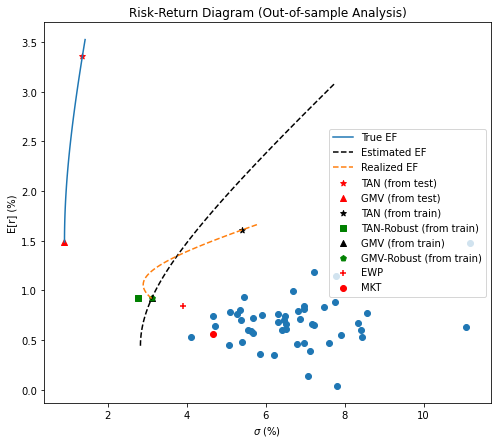

In [222]:
## Out-of-sample Analysis
print('Out-of-sample analysis')
plot_evaluation_results_out_sample (df_train, df_test)

In [231]:
ewp_array = np.array([[evaluate_portfolio_performance_on_data(ewp(48), df_test)['Er'],evaluate_portfolio_performance_on_data(ewp(48), df_test)['sigma'],evaluate_portfolio_performance_on_data(ewp(48), df_test)['Sharpe']]])
gmv_array = np.array([[evaluate_portfolio_performance_on_data(gmv(est_V), df_test)['Er'],evaluate_portfolio_performance_on_data(gmv(est_V), df_test)['sigma'],evaluate_portfolio_performance_on_data(gmv(est_V), df_test)['Sharpe']]])
gmv_robust_array = np.array([[evaluate_portfolio_performance_on_data(gmv_robust, df_test)['Er'],evaluate_portfolio_performance_on_data(gmv_robust, df_test)['sigma'],evaluate_portfolio_performance_on_data(gmv_robust, df_test)['Sharpe']]])
tangency_array = np.array([[evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_test)['Er'],evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_test)['sigma'],evaluate_portfolio_performance_on_data(tangency(est_mu,est_V), df_test)['Sharpe']]])
tangency_robust_array = np.array([[evaluate_portfolio_performance_on_data(t_robust, df_test)['Er'],evaluate_portfolio_performance_on_data(t_robust, df_test)['sigma'],evaluate_portfolio_performance_on_data(t_robust, df_test)['Sharpe']]])
market = np.array([[df_mkt_test.mean(),df_mkt_test.std(),df_mkt_test.mean()/df_mkt_test.std()]])

summary_2 = pd.DataFrame(np.transpose(np.concatenate((market, ewp_array, tangency_array, tangency_robust_array, gmv_array, gmv_robust_array))))
summary_2.columns = ['market', 'ewp', 'tangency','tangency_robust', 'gmv','gmv_robust']
summary_2

,market,ewp,tangency,tangency_robust,gmv,gmv_robust
0,1.010833,0.845597,1.606994,0.926988,0.917728,0.917728
1,3.502378,3.891562,5.395611,2.764384,3.111275,3.111275
2,0.288613,0.217290,0.297834,0.335333,0.294968,0.294968


In [233]:
print(summary)
print(summary_2)

     market       ewp  tangency       gmv
0  0.561467  0.670738  2.865147  0.441403
1  4.657505  4.832560  7.199043  2.825654
2  0.120551  0.138796  0.397990  0.156213
     market       ewp  tangency  tangency_robust       gmv  gmv_robust
0  1.010833  0.845597  1.606994         0.926988  0.917728    0.917728
1  3.502378  3.891562  5.395611         2.764384  3.111275    3.111275
2  0.288613  0.217290  0.297834         0.335333  0.294968    0.294968


In [388]:
df_last = pd.concat([df_train,df_test])
df_mkt_last = pd.concat([df_mkt_train,df_mkt_test])

In [389]:
r =df_mkt_last[1:].values #the return vector
r

array([  7.13,   4.88,  -1.31,   4.62,   1.03,  -6.45,   6.07,  -8.6 ,
         4.66,   1.17,  -3.27,  12.47,   4.39,   1.64,  -2.11,   0.11,
         3.94,   3.85,   3.52,  -2.59, -23.24,  -7.77,   6.81,   4.21,
         4.75,  -2.27,   0.56,  -0.29,   4.79,  -1.25,  -3.31,   3.3 ,
         1.15,  -2.29,   1.49,   6.1 ,  -2.25,   1.57,   4.33,   3.35,
        -1.35,   7.2 ,   1.44,  -0.76,  -3.67,   1.03,   1.16,  -7.85,
         1.11,   1.83,  -3.36,   8.42,  -1.09,  -1.9 , -10.15,  -6.12,
        -1.92,   6.35,   2.46,   4.69,   7.19,   2.65,  -0.28,   3.65,
        -4.94,   4.24,   2.32,  -1.59,   1.29,  -4.19,  10.84,  -0.59,
         1.09,  -2.66,   1.07,   0.3 ,  -2.34,   3.77,  -2.38,   1.19,
         1.02,   4.13,   1.53,   0.93,   0.12,   2.3 ,  -3.05,   2.89,
         0.31,  -0.34,   3.71,  -0.12,   1.41,  -1.89,   1.65,   2.87,
        -2.55,  -4.78,   0.68,   0.58,  -3.03,   2.82,   4.01,  -2.31,
         1.34,  -4.04,   0.86,   1.8 ,   3.63,   2.19,   2.11,   2.9 ,
      

In [390]:
def get_GARCH_variance_rate (omega, alpha, beta):
    
    ###########
    # Evaluate the sequence of variance rate estimates under the GARCH(1,1) model
    # Input: model parameters omega, alpha, and beta
    # Output: a sequence of variance rate estimates in the same size as the return vector r
    ###########
    
    v = np.zeros_like(r) 

    v[0] = np.nan  #discard the first entry of v
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the basic GARCH (1,1) model
    for n in range(2, len(r)):
        v[n] = omega + alpha * r[n-1] * r[n-1] + beta * v[n-1] 
        
    return v


def get_GARCH_volatility (omega, alpha, beta):
    
    ###########
    # Evaluate the sequence of volatility estimates under the GARCH(1,1) model
    # Input: model parameters omega, alpha, and beta
    # Output: a sequence of volatility estimates in the same size as the return vector r
    ###########
    
        
    return np.sqrt( get_GARCH_variance_rate (omega, alpha, beta) )


In [391]:
# Define the maximum likelihood method loss objective function 
# There are three modes: 'GARCH', 'EWMA', 'GARCH-VT'

def Loss(paras, mode):
    
    ###########
    # Evaluate the MLE loss function for EWMA, GARCH(1,1), and GARCH(1,1) model with variance targeting
    # Input: paras:model parameters (possibly scaled) 
    #        mode: should be one of 'GARCH', 'EWMA', or 'GARCH-VT'
    # Output: the MLE loss function value 
    ###########

    #Initialize the parameters
    
    if mode == 'GARCH':
        omega = paras[0]/100000
        alpha = paras[1]/10
        beta = paras[2]
        v = get_GARCH_variance_rate (omega, alpha, beta)
        
        
    if mode == 'EWMA':
        lamb = paras
        
        ########################################
        #double check that lamb < 1 to improve numerical stability
        ########################################
        if lamb > 1:
            #print('Warning: lambda > 1')
            return  - np.exp(lamb - 1)
        ############
        
        v = get_EWMA_variance_rate (lamb)
        
        
    if mode == 'GARCH-VT':
        alpha = paras[0]/10
        beta = paras[1]
        
        ########################################
        #double check that alpha + beta <= 1 to improve numerical stability
        ########################################
        if alpha + beta > 1:
            return  - np.exp(alpha + beta - 1) - 1
        ############
        
        v = get_GARCH_VT_variance_rate (alpha, beta)
        
        
    #delte the first entry of v for likelihood calculation, because it is empty
    v = v[1:] 
    
    '''########################################
    # Provide special values in case of overflow to improve numerical stability
    ########################################
    if np.isinf(np.max(v)):
        print('Overflow warning, ', - np.max(v[np.isfinite(v)]) * 1000)
        return - np.max(v[np.isfinite(v)]) * 1000
    
    if np.min(v) < 0:
        print('Overflow warning, ', - np.exp ( - np.min(v)) * 1000)
        return - np.exp ( - np.min(v)) * 1000
    ############'''
    
    # The MLE loss vector is the negative of the log likelihood (one for each data point)
    losses =  np.log(v) + r[1:]*r[1:]/v
    
    # NB:The "total" loss and "average" loss are equivalent for training purposes
    return np.nanmean(losses)

In [392]:
def garch(d):
    
    #Implement the Maximum Likelihood Method for GARCH(1,1)

    x0 = (1, 1, 1) #Initial guess of the parameter

    omega = x0[0]/100000
    alpha = x0[1]/10
    beta = x0[2]

    res = opt.minimize( lambda x: Loss (x, mode = 'GARCH')  , x0, method='trust-constr', options={'disp': True})

    paras_optimal =  res.x

    omega = paras_optimal[0]/100000
    alpha = paras_optimal[1]/10
    beta = paras_optimal[2]
    
    return get_GARCH_volatility(omega, alpha, beta)[-1]

In [393]:
garch_list = list()
for i in range(len(df_last.columns)):
    r = np.array(df_last.iloc[1:,i])
    
    garch_list.append(garch(2))    

`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 112, CG iterations: 66, optimality: 4.17e-07, constraint violation: 0.00e+00, execution time: 0.096 s.
`xtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 128, CG iterations: 69, optimality: 1.28e-06, constraint violation: 0.00e+00, execution time: 0.099 s.


C:\Users\brand\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 41, function evaluations: 152, CG iterations: 82, optimality: 2.38e-07, constraint violation: 0.00e+00, execution time: 0.12 s.
`xtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 164, CG iterations: 90, optimality: 1.85e-06, constraint violation: 0.00e+00, execution time: 0.13 s.
`xtol` termination condition is satisfied.
Number of iterations: 50, function evaluations: 176, CG iterations: 104, optimality: 1.91e-06, constraint violation: 0.00e+00, execution time: 0.14 s.
`xtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 116, CG iterations: 61, optimality: 3.58e-07, constraint violation: 0.00e+00, execution time: 0.093 s.
`xtol` termination condition is satisfied.
Number of iterations: 95, function evaluations: 340, CG iterations: 203, optimality: 5.17e-06, constraint violation: 0.00e+00, execution time: 0.27 s.
`xtol` termination condition is 

`xtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 116, CG iterations: 68, optimality: 3.58e-07, constraint violation: 0.00e+00, execution time: 0.092 s.


In [394]:
garch_list

[5.793452765668532,
 3.3939446039919363,
 4.555322695261326,
 3.586257635883325,
 5.571368728021546,
 5.566262858341801,
 7.819128270533128,
 6.337023201601266,
 3.5474953601213213,
 3.647883811457549,
 5.259737075520405,
 4.746448893670639,
 4.424192956058691,
 7.181258398526895,
 4.369790951375605,
 5.939317550868423,
 5.02176117756163,
 5.116284923560084,
 6.25421134504957,
 10.50609046183532,
 6.048266673046291,
 5.321237651287981,
 4.638472908971055,
 4.711322371405226,
 7.463363243699376,
 4.6139024690091714,
 15.286765791086978,
 8.4820891943893,
 21.200674082721573,
 10.900924442237264,
 3.3567015014294825,
 5.083043617708446,
 4.089531870275487,
 5.203012497439631,
 5.210470386117175,
 5.055684448983009,
 5.001761731385727,
 4.675248178713772,
 5.143895860221062,
 4.218193581565558,
 4.050074151460085,
 3.8700712951317326,
 3.391845351444573,
 4.532869633098081,
 3.9674411447969984,
 6.41792072604954,
 5.105885005079343,
 4.000851923700625]

In [395]:
corr_mat = np.array(df_train.corr())

In [396]:
std_list = np.array([garch_list])
sd_mat = np.matmul(np.transpose(std_list),std_list)

cov_mat = sd_mat*corr_mat
cov_mat

array([[33.56409495,  7.46559167,  7.49595363, ..., 13.76940941,
        14.26099962,  8.53761634],
       [ 7.46559167, 11.51885997,  7.62992704, ...,  8.22171185,
         7.61218214,  6.49182885],
       [ 7.49595363,  7.62992704, 20.75096486, ..., 14.30968117,
        11.15011851,  8.02097159],
       ...,
       [13.76940941,  8.22171185, 14.30968117, ..., 41.18970645,
        18.8992342 , 13.70909654],
       [14.26099962,  7.61218214, 11.15011851, ..., 18.8992342 ,
        26.07006169, 12.49625444],
       [ 8.53761634,  6.49182885,  8.02097159, ..., 13.70909654,
        12.49625444, 16.00681612]])

In [397]:
pd.DataFrame(cov_mat)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,33.564095,7.465592,7.495954,7.342840,8.796672,12.093968,19.036585,17.059041,8.095253,9.402557,...,12.858470,11.217767,11.313377,10.232989,8.537891,10.765652,9.270999,13.769409,14.261000,8.537616
1,7.465592,11.518860,7.629927,7.989319,10.670917,9.258770,12.571174,11.688297,7.752048,7.049162,...,8.479536,7.216838,7.856628,7.687322,6.816708,8.820404,8.547518,8.221712,7.612182,6.491829
2,7.495954,7.629927,20.750965,9.115638,7.985035,11.017171,18.098266,15.281063,9.024745,8.202370,...,10.219700,9.227074,10.294249,8.134971,7.766582,10.863467,9.689435,14.309681,11.150119,8.020972
3,7.342840,7.989319,9.115638,12.861244,8.401066,9.241608,12.494258,10.127029,8.885575,6.167987,...,8.203805,7.458312,7.141906,7.224181,6.823051,8.530713,8.020444,6.578225,8.281287,6.898405
4,8.796672,10.670917,7.985035,8.401066,31.040150,10.219715,14.153581,11.435556,8.368289,6.685942,...,9.973554,6.643147,10.731891,6.480366,6.895031,8.942366,8.281367,9.148499,8.049628,8.553888
5,12.093968,9.258770,11.017171,9.241608,10.219715,30.983282,29.336257,21.890886,11.665945,13.763636,...,17.821140,15.869520,14.660710,14.359474,13.188513,15.129733,13.171912,21.046470,17.270474,12.087242
6,19.036585,12.571174,18.098266,12.494258,14.153581,29.336257,61.138767,36.683054,16.129886,20.114367,...,24.370086,22.363808,24.013758,20.434807,18.728990,23.591007,19.752542,34.685743,28.486023,20.345430
7,17.059041,11.688297,15.281063,10.127029,11.435556,21.890886,36.683054,40.157863,14.177077,16.756553,...,19.807046,19.090059,19.083011,18.118417,13.585183,20.880588,18.101708,28.081443,22.868058,15.950988
8,8.095253,7.752048,9.024745,8.885575,8.368289,11.665945,16.129886,14.177077,12.584723,7.554264,...,9.901117,9.426929,8.758274,8.390127,7.815668,10.285794,8.940226,10.250757,10.219892,8.603656
9,9.402557,7.049162,8.202370,6.167987,6.685942,13.763636,20.114367,16.756553,7.554264,13.307056,...,12.033194,11.702012,10.636357,11.577112,9.285010,11.706920,9.937033,15.169226,12.587942,9.109521


In [431]:
def random_portfolios(num_portfolios, num_securities, mean_returns, cov_matrix, risk_free_rate):
    """
    Function returns a tuple containing 2 arrays. The results array is a 2D array, columns for the portfolio instnace, rows for the 
    std dev, return, and sharpe ratio respectively. weights record is an array of arrays which contain the weight of each underlying. 
    Each row is for each portfolio, each column for each underlying
    
    Parameters:
        num_portfolios (int): The number of portfolio instances to create 
        num_securities (int): the number of securities used  
        mean_returns (pandas.Series): mean return of each security. len(mean_returns) must match num_securities 
        cov_matrix (pandas.DataFrame): Covariance matrix of shape n * n, where n is num_securities 
        risk_free_rate (numpy.float): the risk free rate used in computation for Sharpe Ratio
    Returns:
        tuple: first element contains 2D array columns for the portfolio instnace, rows for the 
                std dev, return, and sharpe ratio respectively. 
                second element contains weights record, an list of arrays which contain the weight of each underlying.
    
    """
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        
        # Return random floats in the half-open interval [0.0, 1.0) 
        weights = np.random.random(num_securities)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [432]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    """
    Function returns the annualized performance given the weights of the portfolio. 
    Function assumes current means and cov are daily returns 
    
    Parameters:
        weights (numpy.array): array containing relative weights. 
        mean_returns (pandas.Series): mean return of each security. len(mean_returns) must match num_securities 
        cov_matrix (pandas.DataFrame): Covariance matrix of shape n * n, where n is num_securities 
    Returns:
        tuple: Tuple contains the standard deviation and returns of the portfolio, annualized. 
    """
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

In [444]:
def display_simulated_ef_with_random(df, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,num_securities, mean_returns, cov_matrix, risk_free_rate)
    """
    Function displays the efficient frontier, and the weights allocated for the minimum variance portfolio 
    and market optimal portfolio using the Monte Carlo method. 
    
    Parameters 
        df (pandas.DataFrame): Dataframe containing the daily returns 
        mean_returns (pandas.Series): Mean return of each security. len(mean_returns) must match num_securities 
        cov_matrix (pandas.DataFrame): Covariance matrix of shape n * n, where n is num_securities 
        num_portfolios (int): The number of portfolio instances to create 
        risk_free_rate (numpy.float):Tthe risk free rate used in computation for Sharpe Ratio
    
    """
    # Identify the Maximum Sharpe portfolio
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100,2)for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # Identify the Minimum Variance Portfolio 
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    # Output the portfolio return and standard deviation of the Minimum Volatility Portfolio
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Return:", round(rp_min,2))
    print ("Volatility:", round(sdp_min,2))
    print ("Sharpe Ratio:", round(rp_min,2)/round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    # Output the portfolio return and standard deviation of the Maximum Sharpe Portfolio
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Return:", round(rp,2))
    print ("Volatility:", round(sdp,2))
    print ("Sharpe Ratio:", round(rp,2)/round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    # Plot anualized portfolio return vs annualized portfolio volatility
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    # Mark Maximum Sharpe portfolio
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    
    # Mark Minimum variance portfolio
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)
    
    return max_sharpe_allocation

In [445]:
num_securities = len(r_capm)
mean_returns = r_capm
cov_matrix = cov_mat
num_portfolios = 200000 # Simulate 100000 sets of weights
risk_free_rate = 0

--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Return: 0.54
Volatility: 3.55
Sharpe Ratio: 0.15211267605633805


            Agric  Food   Soda   Beer   Smoke  Toys   Fun    Books  Hshld  \
allocation   4.59   3.13   1.66    4.5   3.75   0.17   0.14   0.44   0.65   

            Clths  ...  Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur  \
allocation   0.84  ...   3.68   4.16   3.63   1.14   3.86   4.36   3.76   

            RlEst  Fin    Other  
allocation   2.24   0.07   4.25  

[1 rows x 48 columns]
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Return: 0.55
Volatility: 3.6
Sharpe Ratio: 0.1527777777777778


            Agric  Food   Soda   Beer   Smoke  Toys   Fun    Books  Hshld  \
allocation   5.24    5.1   1.82   2.35   3.29   0.48    2.7   0.54   3.45   

            Clths  ...  Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur 

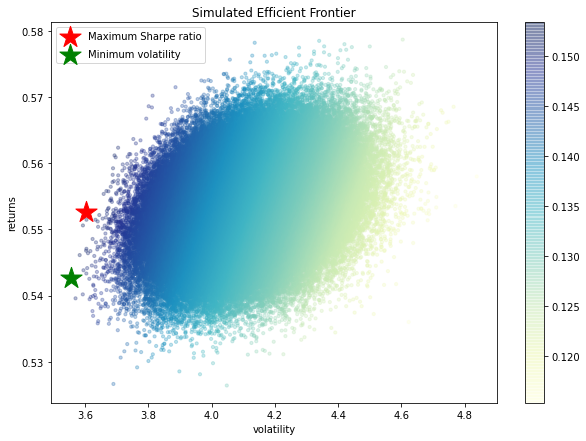

In [447]:
w_simulated = display_simulated_ef_with_random(df_last, mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [456]:
w_simulated.mean()

Agric    5.24
Food     5.10
Soda     1.82
Beer     2.35
Smoke    3.29
Toys     0.48
Fun      2.70
Books    0.54
Hshld    3.45
Clths    3.21
Hlth     4.15
MedEq    0.81
Drugs    3.41
Chems    0.80
Rubbr    1.48
Txtls    2.04
BldMt    0.96
Cnstr    1.08
Steel    2.99
FabPr    1.22
Mach     0.09
ElcEq    1.58
Autos    3.39
Aero     2.07
Ships    1.40
Guns     3.76
Gold     1.48
Mines    0.20
Coal     0.12
Oil      0.09
Util     0.12
Telcm    0.39
PerSv    1.31
BusSv    1.10
Comps    5.34
Chips    4.93
LabEq    1.05
Paper    1.23
Boxes    4.14
Trans    0.66
Whlsl    2.95
Rtail    4.27
Meals    4.77
Banks    0.61
Insur    0.54
RlEst    1.99
Fin      2.78
Other    0.50
dtype: float64